In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.graphics.gofplots as smgf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plt.rcParams.update({'font.size': 14})

# Reziduuri

In [2]:
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# see also http://songhuiming.github.io/pages/2016/11/27/linear-regression-in-python-outliers-leverage-detect/
cars = pd.read_csv('mtcars.csv')
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
mf = 'mpg ~ cyl + disp + hp + drat + wt + qsec + gear + carb'
model = smf.ols(formula=mf, data=cars).fit()

m_fitted_y = model.fittedvalues
m_resid = model.resid

# normalized residuals
m_norm_resid = model.get_influence().resid_studentized_internal
m_norm_resid_sqrt = np.sqrt(np.abs(m_norm_resid))
m_abs_resid = np.abs(m_resid)

m_leverage = model.get_influence().hat_matrix_diag
m_cooks = model.get_influence().cooks_distance[0]

In [4]:
print(OLSInfluence(model).dffits)

(0    -0.258042
1    -0.067827
2    -0.577871
3     0.034220
4     0.147440
5    -0.448855
6    -0.179290
7     0.161296
8    -1.447442
9    -0.090503
10   -0.478989
11    0.653128
12    0.320079
13   -0.085533
14   -0.355058
15   -0.001369
16    1.448193
17    0.882385
18    0.368837
19    1.072963
20   -1.062685
21   -0.360879
22   -0.513829
23   -0.262642
24    0.510759
25   -0.052784
26   -0.340848
27    0.830473
28   -2.823492
29   -0.030148
30    1.226085
31   -0.531366
dtype: float64, 1.0606601717798212)


In [5]:
print(OLSInfluence(model).dfbetas[:29, 8])

[-1.57323170e-01 -3.37986226e-02  3.31171700e-01  6.98409935e-03
  1.85242606e-02  6.62092645e-02 -7.19692122e-02  1.86172764e-02
 -2.12302391e-01 -3.00291627e-03 -6.50592391e-02 -3.78695670e-01
 -9.67719924e-02  2.34278924e-02 -1.46344425e-01 -9.40390373e-05
 -3.60019812e-01 -4.36923001e-01  1.60953644e-01  8.76714780e-03
 -1.32658684e-01  2.78191062e-02  8.70655057e-02  2.66120177e-02
  4.56249232e-02  1.28638239e-02  1.41701658e-01 -3.69623920e-02
  1.35821718e+00]


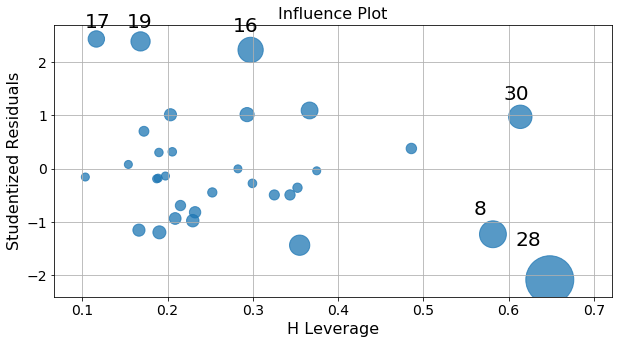

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid()
plt.show()

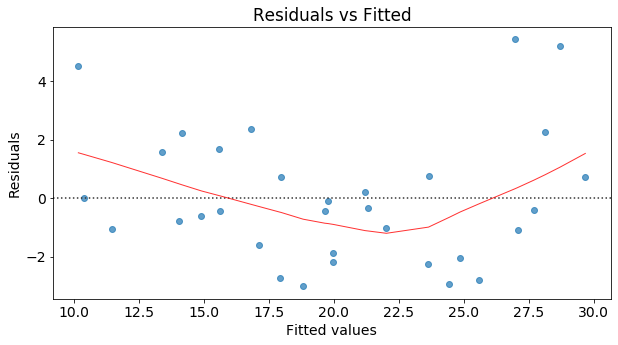

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.residplot(m_fitted_y, 'mpg', data=cars, lowess=True, scatter_kws={'alpha': 0.7},
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

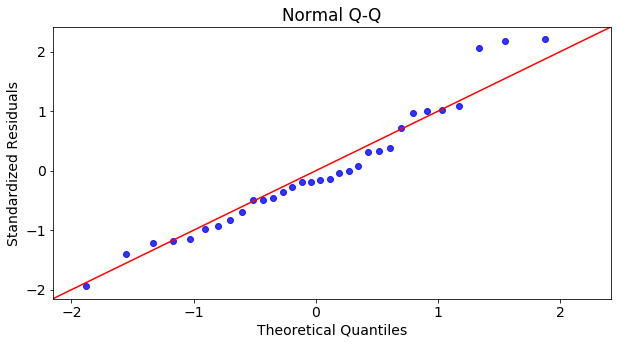

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
qq = smgf.ProbPlot(m_norm_resid)
qq.qqplot(line='45', alpha=0.8, lw=1, ax=ax)
ax.set_title('Normal Q-Q')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Standardized Residuals')
plt.show()

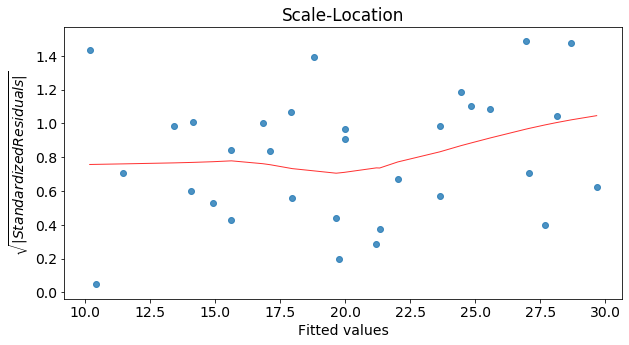

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_fitted_y, m_norm_resid_sqrt, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

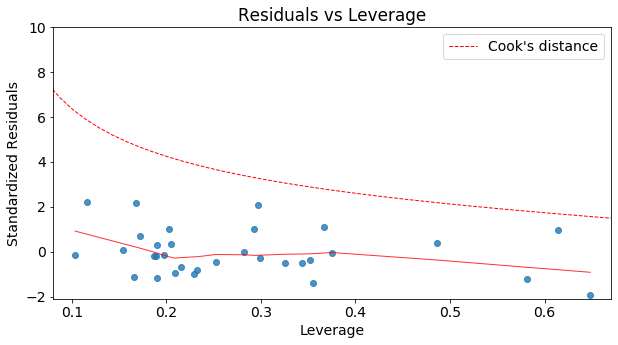

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_leverage, m_norm_resid, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')
ax.set_xlim(0.08, 0.67)
ax.set_ylim(-2.1, 10)

def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    ax.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.7, 50), 'Cook\'s distance') # 0.5 line
#graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
#      np.linspace(0.001, 0.7, 50)) # 1 line
ax.legend(loc='upper right');
plt.show()

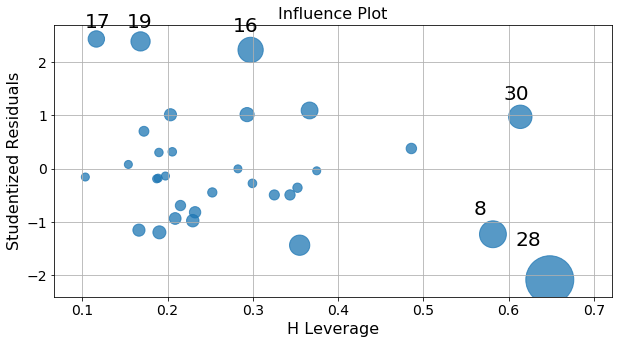

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

# Exemplu de leverage point

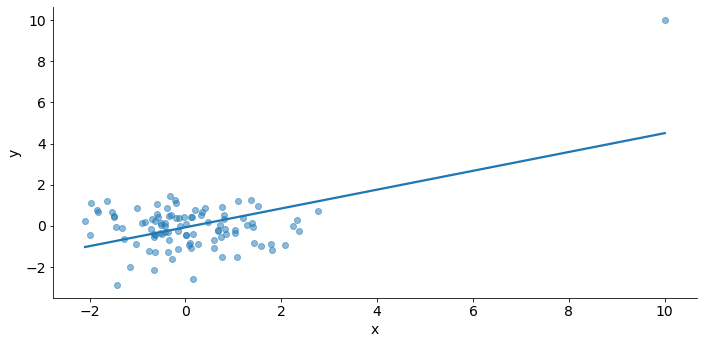

In [12]:
n = 100
x, y = np.r_[10, np.random.randn(n)], np.r_[10, np.random.randn(n)]
df = pd.DataFrame({'x': x, 'y': y})

sns.lmplot(x='x', y='y', data=df, aspect=2, ci=None,  # ci='95'
        scatter_kws={'lw': 1, 'alpha': 0.5})
plt.show()

In [13]:
model = smf.ols(formula='y ~ x', data=df).fit()
print(OLSInfluence(model).dfbetas[:10, 1])

[ 8.3526874  -0.21959795 -0.00881983 -0.0388944  -0.11902359 -0.1809732
 -0.0406769  -0.01875967  0.0299969   0.0141014 ]


In [14]:
print(OLSInfluence(model).summary_frame().hat_diag.values[:10])

[0.4764466  0.02450076 0.01123531 0.01105136 0.0221638  0.03428843
 0.01228779 0.01071417 0.01094775 0.01034898]


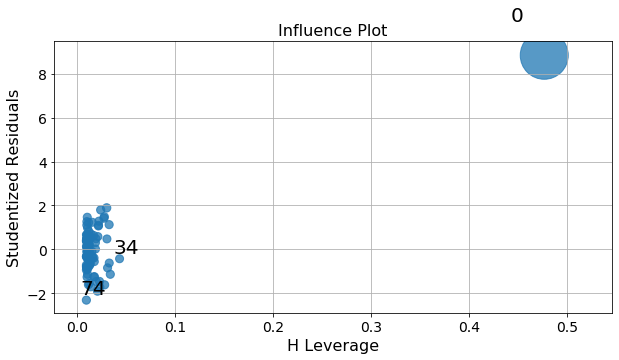

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

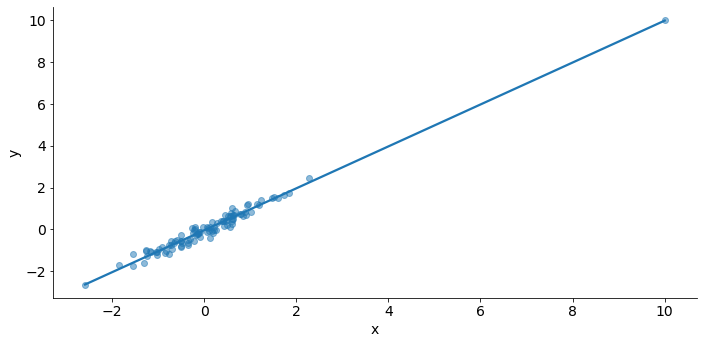

In [16]:
n = 100
x = np.r_[10, np.random.randn(n)] 
y = np.r_[10, x[1:] + .2 * np.random.randn(n)]
df = pd.DataFrame({'x': x, 'y': y})

sns.lmplot(x='x', y='y', data=df, aspect=2, ci=None, # ci='95'
           scatter_kws={'lw': 1, 'alpha': 0.5})
plt.show()

In [17]:
model = smf.ols(formula='y ~ x', data=df).fit()
print(OLSInfluence(model).dfbetas[:10, 1])

[ 0.14042444 -0.00930146 -0.0093873  -0.00335959  0.01725619  0.0056852
  0.13698985 -0.0141643  -0.00632177 -0.03617194]


In [18]:
print(OLSInfluence(model).summary_frame().hat_diag.values[:10])

[0.58082479 0.01773212 0.00993787 0.01015289 0.01116233 0.01030501
 0.02168806 0.01001998 0.01067664 0.01136058]


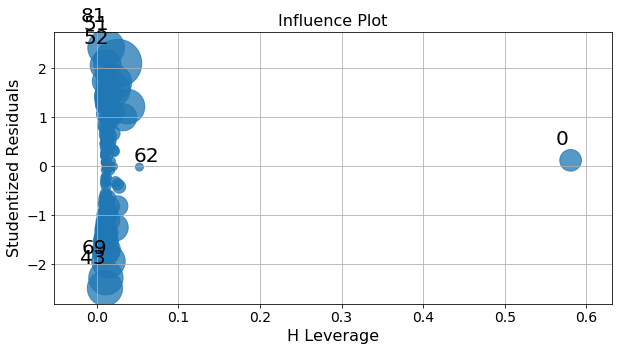

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

In [20]:
st = pd.read_csv('stefanski.txt')
st = np.array([float(y) for x in st.values for y in x[0].split()]).reshape(-1, 5)
st = pd.DataFrame(st)
st.columns = ['v1', 'v2', 'v3', 'v4', 'v5']
st.head()

,v1,v2,v3,v4,v5
0,-0.75052,-0.282230,0.228190,-0.084136,-0.24748
1,-0.39380,-0.074787,-0.013689,0.072776,-0.36026
2,-0.15599,0.358390,-0.118070,0.013815,-0.65672
3,-0.68392,-0.059086,-0.060048,-0.231480,-0.03806
4,-0.59474,0.148360,-0.097664,0.667820,-1.05450


In [21]:
model = smf.ols(formula='v1 ~ v2 + v3 + v4 + v5 - 1', data=st).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     v1   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.050
Method:                 Least Squares   F-statistic:                              30.96
Date:                Tue, 02 Jun 2020   Prob (F-statistic):                    3.85e-25
Time:                        08:38:59   Log-Likelihood:                         -3260.2
No. Observations:                2298   AIC:                                      6528.
Df Residuals:                    2294   BIC:                                      6551.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v2             0.9856      0.128      7.701      0.000       0.735       1.237
v3             0.9715      0.127      7.671      0.000       0.723       1.220
v4             0.8606      0.120      7.197      0.000       0.626       1.095
v5             0.9267      0.083     11.127      0.000       0.763       1.090
==============================================================================
Omnibus:                     1417.819   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.591
Skew:                          -0.141   Prob(JB):                     1.33e-30
Kurtosis:                       1.835   Cond. No.                         4.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

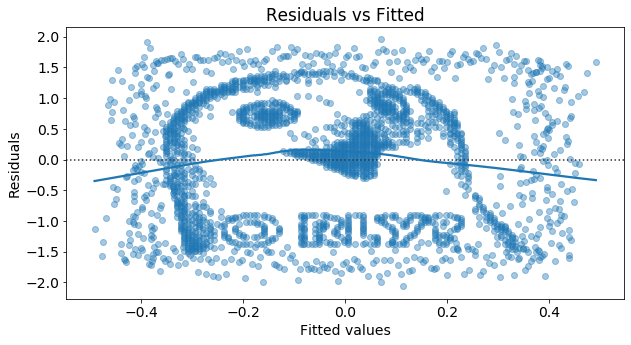

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.residplot(model.fittedvalues, 'v1', data=st, lowess=True, scatter_kws={'alpha': 0.4})
ax.set_title('Residuals vs Fitted') ; ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals') ; plt.show()

# Laborator

__Q1.__ Pentru datele de mai jos (cazul 1 de la curs):

a) reconstruiți graficul de la curs, figurînd mediile pentru ambele grupuri, și reconstruind dreptele de regresie (grupurile și dreptele colorate diferit, în funcție de grup);

b) observați diferența între medii precum și diferența dintre intercept-uri;

c) construiți valorile $y$ pentru a obține, succesiv, graficele din cazurile 2 - 5 de la curs, cu aceleași remarci de la punctul b).

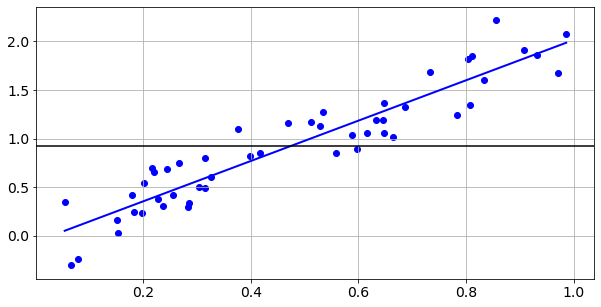

In [23]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n), + np.random.rand(n)]
t = np.array([0]*n + [1]*n)
y = beta0 + t + x * beta1 + np.random.randn(2*n)*sigma
lm1 = sm.OLS(y[:n], sm.add_constant(x[:n])).fit()
lm2 = sm.OLS(y[n:], sm.add_constant(x[n:])).fit()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[:n], y[:n], c='b')
ax.plot(np.sort(x[:n]), lm1.params[0] + lm1.params[1] * np.sort(x[:n]), 'b', lw=2)
ax.axhline(y=y[:n].mean(), c='k')

# fill in your code

ax.grid() ; plt.show()

__Q2.__ Pentru datele sintetice generate mai jos:

a) realizați scatter plot-ul împreună cu dreapta de regresie Y($x_1$); există corelație între $Y$ și $x_1$?

b) figurați, precum la curs, culoarea punctului în funcție de $x_2$;

c) analizați acumdependența liniară dintre reziduurile lui $Y$ și $x_1$, anume dependența dintre $Y$ și $x_1$ în cazul în care din ambele variabile variabilitatea lui $x_2$ a fost deja eliminată. Ce observați?

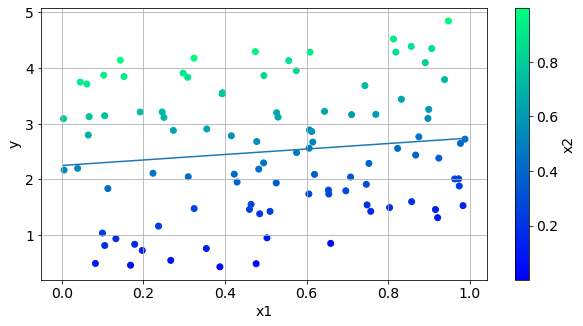

In [24]:
p, n = 1, 100
x2 = np.random.rand(n)
x1 = p * np.random.rand(n) - (1-p) * x2
beta0, beta1, tau, sigma = 0, 1, 4, .01
y = beta0 + x1 * beta1 + tau * x2 + np.random.randn(n)*sigma
df = pd.DataFrame({'x1': x1, 'y': y})
params = smf.ols(formula='y ~ x1', data=df).fit().params

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cm = plt.cm.get_cmap('winter')
sc = ax.scatter(x1, y, c=x2, cmap=cm)
x = np.linspace(min(x1), max(x1), 10)
ax.plot(x, params[0] + x * params[1])
ax.set_xlabel('x1') ; ax.set_ylabel('y')
fig.colorbar(sc, ax=ax).set_label('x2')
ax.grid() ; plt.show()

__Q3.__ Pentru setul seatbelts, potriviți un model liniar pentru răspunsul deaths în funcție de predictorii kms și PetrolPrice. Interpretați rezultatele.

In [25]:
seatbelts = pd.read_csv('seatbelts.csv')
seatbelts.head()

,Unnamed: 0,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,1,107,1687,867,269,9059,0.102972,12,0
1,2,97,1508,825,265,7685,0.102363,6,0
2,3,102,1507,806,319,9963,0.102062,12,0
3,4,87,1385,814,407,10955,0.100873,8,0
4,5,119,1632,991,454,11823,0.101020,10,0


__Q4.__ Pentru același set seatbelts, comparați coeficientul (panta) pentru kms cu și fără includerea PetrolPrice în model.

__Q5.__ Realizați același lucru pentru PetrolPrice, acum incluzînd (sau nu) kms în model.

__Q6.__ Realizați analiza reziduurilor folosind dfbetas și hat values. Căutați minime sau maxime. Extrema este la distanță de un ordin de mărime?

__Q7.__ Ridicați diagramele Residuals vs. Fitted, Q-Q plot, Scale-Location, Residuals vs. Leverage (aceasta din urmă ridicați-o folosind Studentized Residuals vs. H Leverage). Încercați să explicați ce observați.